In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Install language libraries
!pip install googletrans==4.0.0-rc1
!pip install whatthelang
!pip install swifter

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.2 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17396 sha256=32b3b0f51f8087c3e1bcd53fdd450ed60b61fbcc6daa03662f45381f425e9ba6
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling 

In [3]:
london_listings=pd.read_csv("/content/drive/MyDrive/Sample 2_Airbnb_listings (2).csv")
reviews=pd.read_csv("/content/drive/MyDrive/Sample 2_Airbnb_reviews (2).csv")

In [4]:
reviews.shape

(100000, 6)

In [5]:
#Removing automated reviews
reviews['comments'] = reviews['comments'].fillna('')
reviews=reviews[~reviews['comments'].str.contains('automated posting', case=False)]

In [6]:
reviews.shape

(98344, 6)

# Data Preparation and Cleaning

In [7]:
#Rename ID col to listing ID to merge with reviews data
london_listings.rename(columns={'id':"listing_id"}, inplace=True)

In [8]:
#Drop columns that do not contribute useful information to analysis
london_listings.drop(columns=['listing_url','scrape_id','last_scraped','picture_url','host_name','host_url','host_id','host_thumbnail_url','host_picture_url','calendar_last_scraped','license','bathrooms','calendar_updated','neighbourhood_group_cleansed','host_listings_count','host_total_listings_count','host_neighbourhood'], inplace=True)

In [9]:
#Convert data types and format
london_listings[['host_since','first_review','last_review']]= london_listings[['host_since','first_review','last_review']].apply(pd.to_datetime,format='%Y-%m-%d')
#Price to float
london_listings['price'] = london_listings['price'].replace('[\$,]', '', regex=True).astype(float)
#Percentages to Numbers
london_listings['host_response_rate']=london_listings['host_response_rate'].str.rstrip("%").astype('float')/100
london_listings['host_acceptance_rate']=london_listings['host_acceptance_rate'].str.rstrip("%").astype('float')/100

In [10]:
#All listings are from UK (London)
london_listings['neighbourhood'].isnull().sum()

11713

In [11]:
#There are ~12k listings with no neighbourhoods
#All listings have a value for neigh_cleansed.

london_listings[london_listings['neighbourhood'].isnull()]['neighbourhood_cleansed'].unique()

array(['Islington', 'Haringey', 'Lambeth', 'Ealing', 'Tower Hamlets',
       'Newham', 'Enfield', 'Westminster', 'Hammersmith and Fulham',
       'Barnet', 'Hackney', 'Redbridge', 'Kingston upon Thames', 'Brent',
       'Kensington and Chelsea', 'Merton', 'Camden', 'Hillingdon',
       'Lewisham', 'Southwark', 'Croydon', 'Hounslow', 'Wandsworth',
       'Sutton', 'Harrow', 'Richmond upon Thames', 'Waltham Forest',
       'Bromley', 'Greenwich', 'City of London', 'Bexley', 'Havering',
       'Barking and Dagenham'], dtype=object)

In [12]:
#Sanity Check- All are from london
#So we'll fill null neighbourhoods accordingly with London
london_listings['neighbourhood'].fillna('London',inplace=True)


In [13]:
#1. Review ratings are essential to assess performance so listings with nulls for First Review/Last review dates are dropped
#As they don't have any of the rating information
listings=london_listings[london_listings['first_review'].notnull()].copy()
listings.shape

(21074, 57)

In [14]:
#Check for duplicates
listings[listings.duplicated()]

,listing_id,name,description,neighborhood_overview,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month


## Filling Null Values

In [15]:
nulls=pd.DataFrame(listings.isnull().sum())
nulls[nulls[0]!=0]

,0
name,1
description,463
neighborhood_overview,6523
host_since,555
host_location,587
host_about,8818
host_response_time,11458
host_response_rate,11458
host_acceptance_rate,10395
host_is_superhost,555


In [16]:
#Fill Blanks for Descriptive Textual columns with "No Description"
listings[['name','description','host_location','host_about','neighborhood_overview']]=listings[['name','description','host_location','host_about','neighborhood_overview']].fillna("No Description")

In [17]:
nulls=pd.DataFrame(listings.isnull().sum())
nulls[nulls[0]!=0]

,0
host_since,555
host_response_time,11458
host_response_rate,11458
host_acceptance_rate,10395
host_is_superhost,555
host_has_profile_pic,555
host_identity_verified,555
bathrooms_text,20
bedrooms,1201
beds,110


In [18]:
#Fill Blanks for boolean

#Assume blanks are False for these columns
listings['host_is_superhost'].fillna('f',inplace=True)
#Assume blanks are not identity verified and has no profile pic
listings['host_identity_verified'].fillna('f',inplace=True)
listings['host_has_profile_pic'].fillna('f',inplace=True)

In [19]:
listings['host_since'].dt.year.value_counts(normalize=True)*100

2015.0    17.978459
2016.0    14.859399
2014.0    14.230713
2017.0    10.604805
2018.0     9.742190
2013.0     9.708075
2019.0     8.294751
2012.0     7.778157
2011.0     3.279887
2020.0     2.651201
2010.0     0.575077
2021.0     0.146206
2009.0     0.131585
2008.0     0.019494
Name: host_since, dtype: float64

Median Date: 2015-10-07 00:00:00


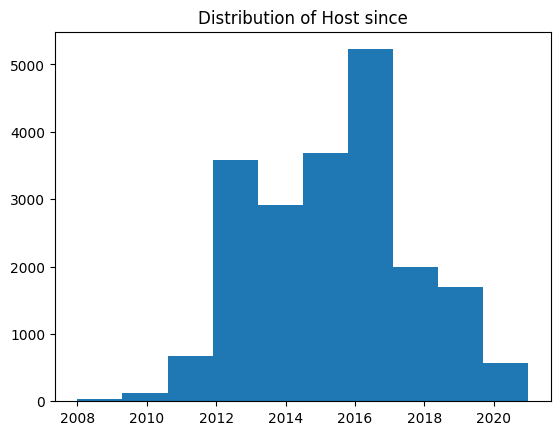

In [20]:
#Host Since column
print("Median Date:",listings['host_since'].median())
plt.hist(listings['host_since'].dt.year)
plt.title("Distribution of Host since")
plt.show()

#Fill Na with median
listings['host_since'].fillna(listings['host_since'].median(),inplace=True)

In [21]:
#Host Response Time
listings['host_response_time'].fillna("Unknown",inplace=True)

Mean:  0.88
Median: 1.0
Mode: 0    1.0
Name: host_response_rate, dtype: float64


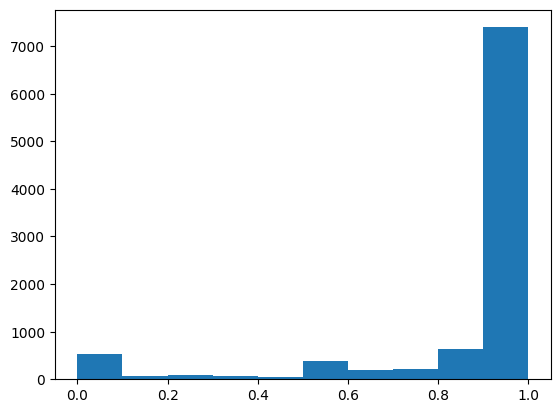

In [22]:
#Host Response Rate
print("Mean: ",round(listings['host_response_rate'].mean(),2))
print("Median:",listings['host_response_rate'].median())
print("Mode:",listings['host_response_rate'].mode())

plt.hist(listings['host_response_rate'])
plt.show()

#Fill with Mean
listings['host_response_rate'].fillna(round(listings['host_response_rate'].mean(),2),inplace=True)

Mean:  0.79
Median: 0.94
Mode: 0    1.0
Name: host_acceptance_rate, dtype: float64


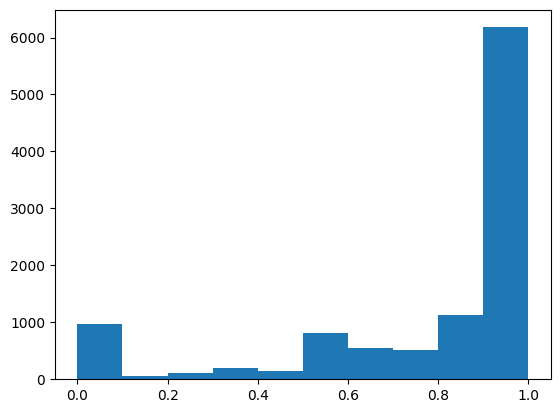

In [23]:
#Host Acceptance Rate
print("Mean: ",round(listings['host_acceptance_rate'].mean(),2))
print("Median:",listings['host_acceptance_rate'].median())
print("Mode:",listings['host_acceptance_rate'].mode())

plt.hist(listings['host_acceptance_rate'])
plt.show()

#Fill with MEDIAN
listings['host_acceptance_rate'].fillna(listings['host_acceptance_rate'].median(),inplace=True)

In [24]:
#Beds
#Fill with Median
listings['beds'].fillna(listings['beds'].median(),inplace=True)

In [25]:
#Bedrooms
listings['bedrooms'].fillna(listings['bedrooms'].median(),inplace=True)

In [26]:
#Bathrooms Text
listings['bathrooms_text'].value_counts(normalize=True)*100
listings['bathrooms_text'].fillna('2 baths',inplace=True)

In [27]:
nulls=pd.DataFrame(listings.isnull().sum())
nulls[nulls[0]!=0]

,0
review_scores_rating,696
review_scores_accuracy,715
review_scores_cleanliness,712
review_scores_checkin,737
review_scores_communication,720
review_scores_location,739
review_scores_value,737


In [28]:
listings['review_scores_rating'].fillna(listings['review_scores_rating'].mean(),inplace=True)

listings['review_scores_accuracy'].fillna(listings['review_scores_accuracy'].mean(),inplace=True)
listings['review_scores_cleanliness'].fillna(listings['review_scores_cleanliness'].median(),inplace=True)
listings['review_scores_checkin'].fillna(listings['review_scores_checkin'].median(),inplace=True)
listings['review_scores_location'].fillna(listings['review_scores_location'].median(),inplace=True)
listings['review_scores_communication'].fillna(listings['review_scores_communication'].median(),inplace=True)
listings['review_scores_value'].fillna(listings['review_scores_value'].mean(),inplace=True)

In [29]:
listings['host_verifications'].fillna("Unknown",inplace=True)

In [30]:
nulls=pd.DataFrame(listings.isnull().sum())
nulls[nulls[0]!=0]

,0


##Preprocessing columns

In [31]:
#Basic text columns to lowercase
listings[['bathrooms_text','property_type','room_type']]=listings[['bathrooms_text','property_type','room_type']].apply(lambda x: x.str.lower())

In [32]:
listings['host_response_time_type']=np.where(listings['host_response_time'].eq('within an hour'),"Very Quick",
                                               np.where(listings['host_response_time'].eq('within a few hours'),"Moderate",
                                                        np.where(listings['host_response_time'].eq('within a day'),"Slow",
                                                                 np.where(listings['host_response_time'].eq('a few days or more'),"Very Slow","Unknown"))
                                                        ))

In [33]:
listings['host_response_time_type'].value_counts()

Unknown       11458
Very Quick     5054
Moderate       2093
Slow           1664
Very Slow       805
Name: host_response_time_type, dtype: int64

In [34]:
#Dates into number of Years
def years_old(c_date):
    return(2021 - (c_date))

listings['host_since(yrs)'] = listings['host_since'].dt.year.apply(years_old)
listings['yrs_first_review']=listings['first_review'].dt.year.apply(years_old)
listings['yrs_last_review']=listings['last_review'].dt.year.apply(years_old)


listings[['host_since(yrs)','yrs_first_review','yrs_last_review']]



,host_since(yrs),yrs_first_review,yrs_last_review
0,2,1,0
1,5,4,2
2,9,9,2
4,6,3,1
5,5,2,1
...,...,...,...
29995,7,2,2
29996,7,6,1
29997,4,3,2
29998,8,5,3


In [35]:
#Bathroom text and splitting into types and count
listings['bathrooms_text']=listings['bathrooms_text'].str.replace(r'\bhalf-', '0.5')

#Assume it's private where shared is not explicitly mentioned
listings['bathroom_count']=listings['bathrooms_text'].str.extract(r'(\d+(?:\.\d+)?)').astype('float')
listings['bathroom_type']='private'
listings.loc[listings['bathrooms_text'].str.contains('shared',case=False),'bathroom_type']='shared'

listings[['bathroom_count','bathrooms_text','bathroom_type']]

<ipython-input-35-5e4794c86e53>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  listings['bathrooms_text']=listings['bathrooms_text'].str.replace(r'\bhalf-', '0.5')


,bathroom_count,bathrooms_text,bathroom_type
0,1.0,1 bath,private
1,1.0,1 bath,private
2,1.0,1 private bath,private
4,1.0,1 shared bath,shared
5,1.5,1.5 baths,private
...,...,...,...
29995,1.0,1 bath,private
29996,1.0,1 shared bath,shared
29997,1.0,1 shared bath,shared
29998,1.0,1 bath,private


In [36]:
#Count of Amenities
ame_text=listings['amenities']
ame_text=' '.join(ame_text).lower()

listings['amenities']=listings['amenities'].apply(eval)

count_amen=[]
for i in listings['amenities']:
  count_amen.append(len(i))
listings['count_amenities']=count_amen

listings['count_amenities']

0        45
1        21
2        25
4        29
5        32
         ..
29995    14
29996    16
29997    22
29998    22
29999    25
Name: count_amenities, Length: 21074, dtype: int64

In [37]:
listings=listings[listings['count_amenities']!=0]

In [38]:
#Bin Priced into ranges
price_bins={
    (5.0,50.0):'Pocket Friendly (5-50 $)',
    (50.0,100.0):'Economical (50-100 $)',
    (100.0,200.0):'Mid Range (100-200 $)',
    (200.0,300.0):'Moderately High price (200-300 $)',
    (300.0, 400.0):'Higher End price (300-400 $)',
    (400.0,500.0):'Premium price (400-500 $)',
    (500.0,18000.0):'Luxury price (>$500)'
}

def bin_price(price):
    for (low, high), price_type in price_bins.items():
        if low <= price < high:
            return price_type

listings['Price Type'] = listings['price'].apply(bin_price)

<ipython-input-38-d8d83bcba0ae>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings['Price Type'] = listings['price'].apply(bin_price)


In [39]:
listings['Price Type'].value_counts(normalize=True)*100

Economical (50-100 $)                35.200836
Pocket Friendly (5-50 $)             30.642864
Mid Range (100-200 $)                24.679518
Moderately High price (200-300 $)     5.792422
Higher End price (300-400 $)          1.846928
Luxury price (>$500)                  1.120501
Premium price (400-500 $)             0.716931
Name: Price Type, dtype: float64

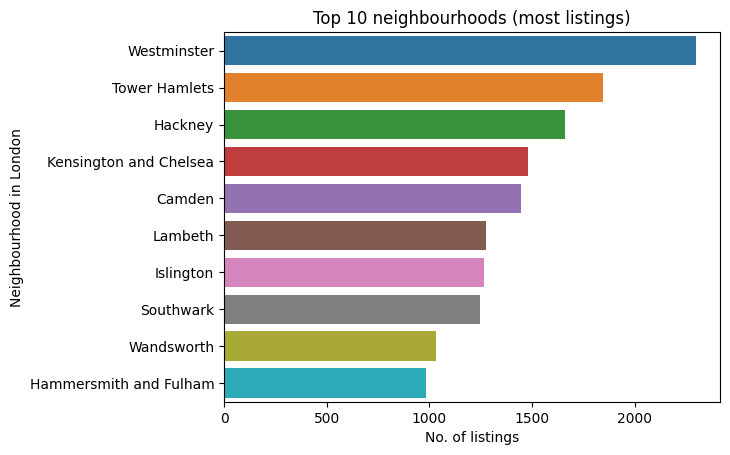

In [40]:
high_neigh=listings['neighbourhood_cleansed'].value_counts().head(10).rename_axis('name').reset_index(name='counts')
sns.barplot(y='name',x='counts',data=high_neigh)
plt.xlabel('No. of listings')
plt.ylabel('Neighbourhood in London')
plt.title('Top 10 neighbourhoods (most listings)')
plt.show()

In [41]:
top10_neighs=['Westminster','Tower Hamlets','Hackney','Kensington and Chelsea','Camden','Lambeth','Islington','Southwark','Wandsworth','Hammersmith and Fulham']

In [42]:
listings['intop10_Neigh'] = listings['neighbourhood_cleansed'].apply(lambda x: 't' if x in top10_neighs else 'f')

In [43]:
listings['intop10_Neigh'].value_counts()

t    14529
f     6533
Name: intop10_Neigh, dtype: int64

In [44]:
custom_stopwords=set(["london","flat","room","thing","stay","apartment","will","house","travel","place","things","note","guest","no","description","Unknown","term","soho","camden","area","automated"])


In [45]:
#Function to clean text data
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize

from nltk.stem import WordNetLemmatizer
from nltk import ngrams

from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

from bs4 import BeautifulSoup
import re
stopwords = set(STOPWORDS)
stopwords.update(custom_stopwords)

def clean_text_func(my_text):

  descp_text=my_text.tolist()
  descp_text=' '.join(descp_text).lower()


  soup = BeautifulSoup(descp_text, "html.parser")
  clean_text = soup.get_text(separator=" ")

  # Remove special characters using regex
  clean_text = re.sub(r"[^a-zA-Z0-9\s]", "", clean_text)

  #Tokenize
  tokens = word_tokenize(clean_text)
  filtered_tokens = [word for word in tokens if word.lower() not in stopwords]
  filtered_text = ' '.join(filtered_tokens)

  return filtered_text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


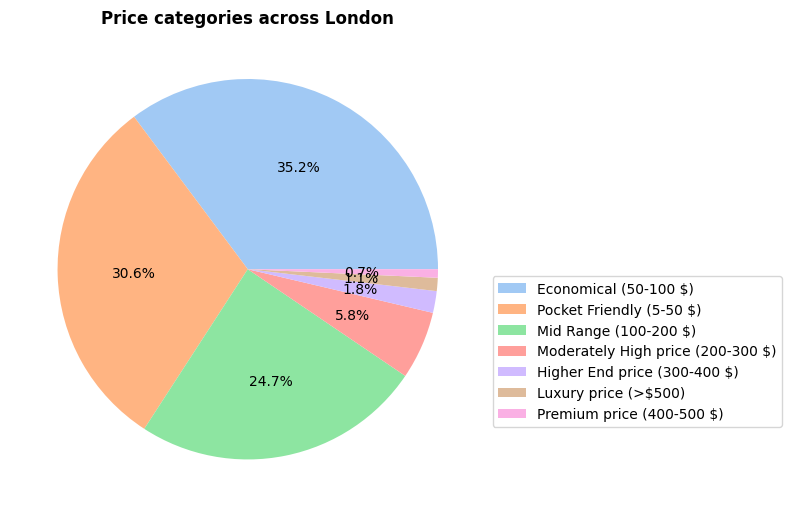

In [46]:
colors = sns.color_palette('pastel')[0:10]

plt.figure(figsize=(8, 8))
plt.pie(listings['Price Type'].value_counts(normalize=True)*100,labels=None,autopct='%1.1f%%',colors=colors)
plt.legend(listings['Price Type'].value_counts().index,bbox_to_anchor=(1, 0.5))
plt.title("Price categories across London", fontweight='bold',size='large')
plt.tight_layout()
plt.show()

##Filtering Competitor Subset
###Accommodates<=6
###Price<=100
###Neighbourhood

In [47]:
uk_comp_subset=listings[(listings['accommodates']>0) & (listings['accommodates']<=6) &(listings['price']<=100)].copy()
uk_comp_subset.shape

(14372, 66)

##Listing under consideration is in Camden so neighbourhoods close to that are picked for comparative analysis
Listing ID: 39934731


In [48]:
camden_neighs=['Westminster','Islington','City of London','Lambeth','Southwark','Camden']

In [49]:
camden_listings=uk_comp_subset[uk_comp_subset['neighbourhood_cleansed']=='Camden'].copy()

In [50]:
#Competitor Subset Plot
import plotly.express as px
fig = px.scatter_mapbox(uk_comp_subset[uk_comp_subset['neighbourhood_cleansed'].isin(camden_neighs)], lat = 'latitude', lon = 'longitude',
                        zoom = 10,
                        color='neighbourhood_cleansed',
                        color_continuous_scale=px.colors.sequential.Viridis,
                        mapbox_style = 'open-street-map')
fig.show()

In [51]:
camden_neigh_listings=uk_comp_subset[uk_comp_subset['neighbourhood_cleansed'].isin(camden_neighs)].copy()

In [52]:
camden_neigh_listings.shape

(4669, 66)

In [53]:
camden_neigh_listings=camden_neigh_listings[camden_neigh_listings['listing_id']!=39934731]

# Competitor Overview

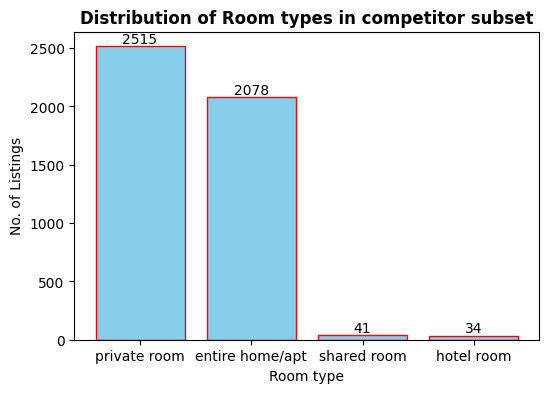

In [54]:
#Room Types in Comp subset
fig, ax = plt.subplots(figsize=(6,4))
bars=plt.bar(camden_neigh_listings['room_type'].value_counts().index,camden_neigh_listings['room_type'].value_counts(),color='skyblue',edgecolor='red')
ax.bar_label(bars)
plt.ylabel("No. of Listings")
plt.xlabel("Room type")
plt.title("Distribution of Room types in competitor subset",fontweight='bold',size='large')
plt.show()

In [55]:
camden_neigh_listings=camden_neigh_listings[camden_neigh_listings['price']<=100]

In [56]:
camden_neigh_listings['Price Type'].value_counts()

Economical (50-100 $)       2782
Pocket Friendly (5-50 $)    1656
Mid Range (100-200 $)        230
Name: Price Type, dtype: int64

In [57]:
cheaper_camden_neigh_listings=camden_neigh_listings[camden_neigh_listings['price']<=70].copy()

In [58]:
cheaper_camden_neigh_listings.shape

(2945, 66)

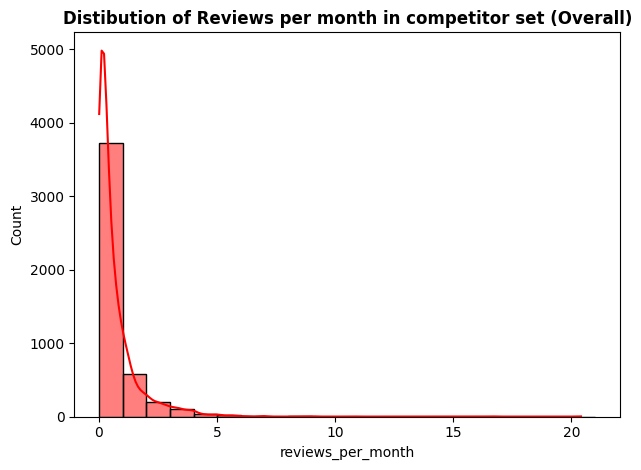

In [59]:
sns.histplot(data=camden_neigh_listings,x='reviews_per_month',kde=True,binwidth=1,color='red')
plt.title('Distibution of Reviews per month in competitor set (Overall)',fontweight='bold',size='large')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Review Score distribution for competitor listings')

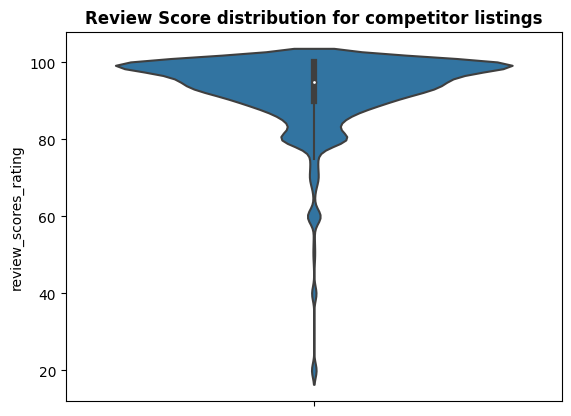

In [60]:
#Overall Review rating in from which we'll use >80 for benchmarking
sns.violinplot(data=camden_neigh_listings,y='review_scores_rating')
plt.title("Review Score distribution for competitor listings", fontweight='bold',size='large')

##Exploratory Analysis

Listing under consideration ID: 39934731

In [61]:
conc_listing=camden_listings[camden_listings['listing_id']==39934731]

In [62]:
q_a_listing_dict={
    'Questions':[ 'Listing location: ',
                 'Listing type:',
                 'Listing accommodation capacity:',
                 'Listing Price type: ',
                 'Is it instantly bookable ?',
                 'Listing bathroom type:',
                  'How many amenities does it have ?',
                 'Listing review rating (on 100):',
                  'Availability in next 30 days: '],

    'Answers':[str(conc_listing['neighbourhood_cleansed'].values[0]),
               str(conc_listing['property_type'].values[0]),
               str(conc_listing['accommodates'].values[0]),
               str(conc_listing['Price Type'].values[0]),
               "No",
               str(conc_listing['bathroom_type'].values[0]),
               int(conc_listing['count_amenities'].values[0]),
               str(conc_listing['review_scores_rating'].values[0]),
               str(conc_listing['availability_30'].values[0])]
}

listing_descp=pd.DataFrame(q_a_listing_dict)
listing_descp

,Questions,Answers
0,Listing location:,Camden
1,Listing type:,entire apartment
2,Listing accommodation capacity:,3
3,Listing Price type:,Economical (50-100 $)
4,Is it instantly bookable ?,No
5,Listing bathroom type:,private
6,How many amenities does it have ?,22
7,Listing review rating (on 100):,64.0
8,Availability in next 30 days:,9


In [63]:
host_charac={
    "Questions":['How long has the host been with Airbnb ?',
                 'Is the host a SuperHost?',
                 'Is the host identity verified ?',
                 'Host response time and rate:',
                 'Number of listings the host has:',
                 'Host Acceptance Rate (%): '
              ],

    "Answers":[str(conc_listing['host_since(yrs)'].values[0])+" years",
               "No",
               "Yes",
               str(conc_listing['host_response_time'].values[0])+" "+str(conc_listing['host_response_rate'].values[0]*100)+" %",
               str(conc_listing['calculated_host_listings_count'].values[0]),
               str(conc_listing['host_acceptance_rate'].values[0]*100)+"%",

               ]
}

host_descp=pd.DataFrame(host_charac)
host_descp

,Questions,Answers
0,How long has the host been with Airbnb ?,8 years
1,Is the host a SuperHost?,No
2,Is the host identity verified ?,Yes
3,Host response time and rate:,within a few hours 86.0 %
4,Number of listings the host has:,9
5,Host Acceptance Rate (%):,93.0%


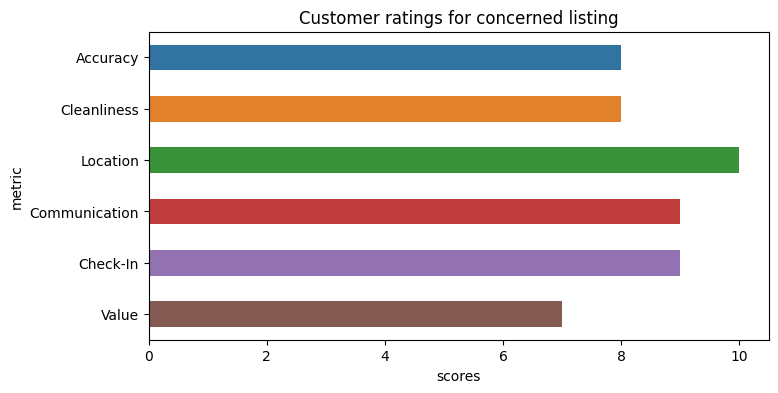

In [64]:
#How much has the listing scored?
ratings={'metric':['Accuracy','Cleanliness','Location','Communication','Check-In','Value'],

         'scores':[float(conc_listing['review_scores_accuracy'].values[0]),
                   float(conc_listing['review_scores_cleanliness'].values[0]),
                   float(conc_listing['review_scores_location'].values[0]),
                   float(conc_listing['review_scores_communication'].values[0]),
                   float(conc_listing['review_scores_checkin'].values[0]),
                   float(conc_listing['review_scores_value'].values[0])
                         ]
         }

scores=pd.DataFrame(ratings)

plt.figure(figsize=(8,4))
sns.barplot(x=scores['scores'],y=scores['metric'],width=0.5)
plt.title("Customer ratings for concerned listing")
plt.show()

In [65]:
#Other camden listings
other_camden=camden_listings[camden_listings['listing_id']!=39934731]
#Score >80
high_perform_neigh=camden_neigh_listings[camden_neigh_listings['review_scores_rating']>=80]
high_perform_cheaper=high_perform_neigh[high_perform_neigh['price']<=70]

poor_perform_neigh=camden_neigh_listings[camden_neigh_listings['review_scores_rating']<=60]
poor_perform_cheaper=poor_perform_neigh[poor_perform_neigh['price']<=70]


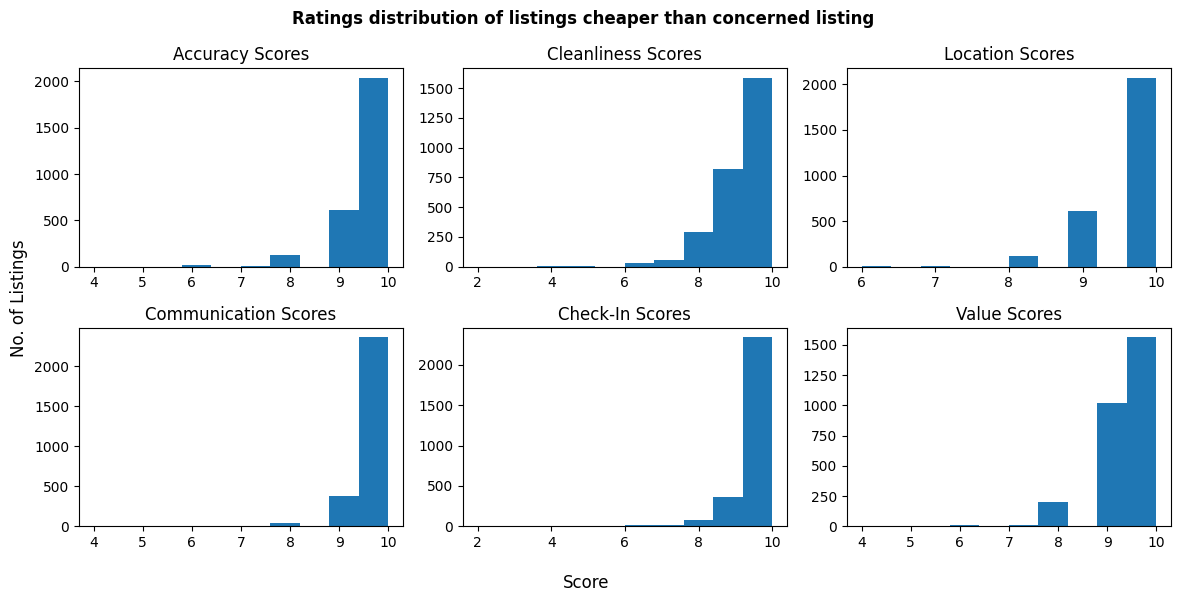

In [66]:
fig,ax=plt.subplots(2,3, figsize=(12,6))
ax[0,0].hist(high_perform_cheaper['review_scores_accuracy'])
ax[0,0].set_title("Accuracy Scores")

ax[0,1].hist(high_perform_cheaper['review_scores_cleanliness'])
ax[0,1].set_title("Cleanliness Scores")

ax[0,2].hist(high_perform_cheaper['review_scores_location'])
ax[0,2].set_title("Location Scores")

ax[1,0].hist(high_perform_cheaper['review_scores_communication'])
ax[1,0].set_title("Communication Scores")

ax[1,1].hist(high_perform_cheaper['review_scores_checkin'])
ax[1,1].set_title("Check-In Scores")

ax[1,2].hist(high_perform_cheaper['review_scores_value'])
ax[1,2].set_title("Value Scores")


fig.supxlabel('Score')
fig.supylabel('No. of Listings')

plt.suptitle("Ratings distribution of listings cheaper than concerned listing ",fontweight='bold',size='large')

plt.tight_layout()
plt.show()


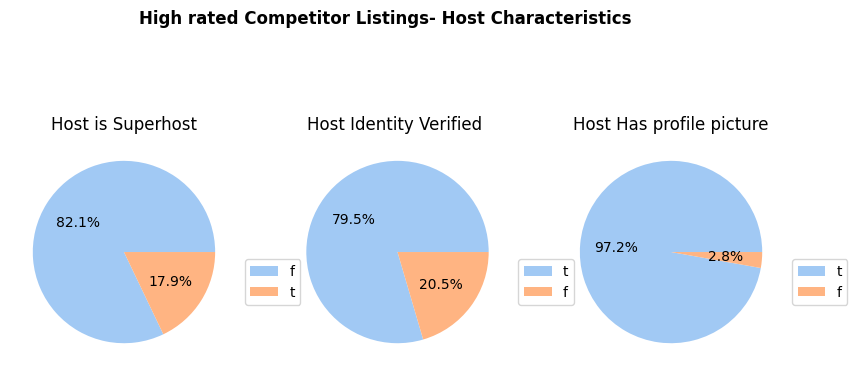

In [67]:


fig, ax = plt.subplots(1,3, figsize=(10,5))

ax[0].pie(high_perform_neigh['host_is_superhost'].value_counts(),labels=None,autopct='%1.1f%%',colors=colors)
ax[0].legend(high_perform_neigh['host_is_superhost'].value_counts().index,bbox_to_anchor=(1, 0.5))
ax[0].set_title("Host is Superhost")

ax[1].pie(high_perform_neigh['host_identity_verified'].value_counts(),labels=None,autopct='%1.1f%%',colors=colors)
ax[1].legend(high_perform_neigh['host_identity_verified'].value_counts().index,bbox_to_anchor=(1, 0.5))
ax[1].set_title("Host Identity Verified ")

ax[2].pie(high_perform_neigh['host_has_profile_pic'].value_counts(),labels=None,autopct='%1.1f%%',colors=colors)
ax[2].legend(high_perform_neigh['host_has_profile_pic'].value_counts().index,bbox_to_anchor=(1, 0.5))
ax[2].set_title("Host Has profile picture")

fig.suptitle('High rated Competitor Listings- Host Characteristics',fontweight='bold',size='large')
plt.show()

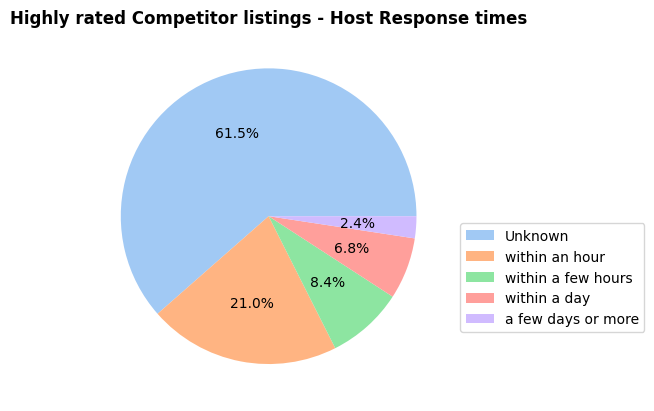

In [68]:
#Host response time

colors = sns.color_palette('pastel')[0:10]
plt.pie(high_perform_neigh['host_response_time'].value_counts(),labels=None, autopct='%1.1f%%',colors=colors)
plt.legend(high_perform_neigh['host_response_time']
.value_counts().index,bbox_to_anchor=(1, 0.5))
plt.title("Highly rated Competitor listings - Host Response times",loc='center',fontweight='bold',size='large')

plt.show()

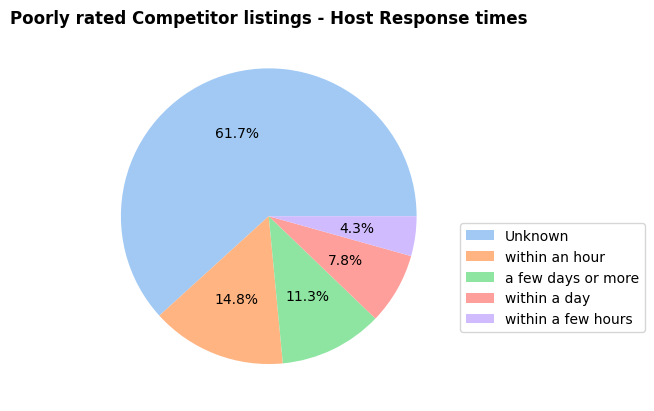

In [69]:
colors = sns.color_palette('pastel')[0:10]
plt.pie(poor_perform_neigh['host_response_time'].value_counts(),labels=None, autopct='%1.1f%%',colors=colors)
plt.legend(poor_perform_neigh['host_response_time'].value_counts().index,bbox_to_anchor=(1, 0.5))
plt.title("Poorly rated Competitor listings - Host Response times",loc='center',fontweight='bold',size='large')

plt.show()

In [70]:
conc_amen=list(conc_listing['amenities'].values[0])

In [71]:
conc_amen

['Kitchen',
 'Bed linens',
 'Hangers',
 'Long term stays allowed',
 'Wifi',
 'Carbon monoxide alarm',
 'Heating',
 'Essentials',
 'Washer',
 'Hair dryer',
 'Dedicated workspace',
 'Refrigerator',
 'Cooking basics',
 'Coffee maker',
 'Oven',
 'Hot water',
 'Lockbox',
 'Dishes and silverware',
 'Stove',
 'TV',
 'Smoke alarm',
 'Security cameras on property']

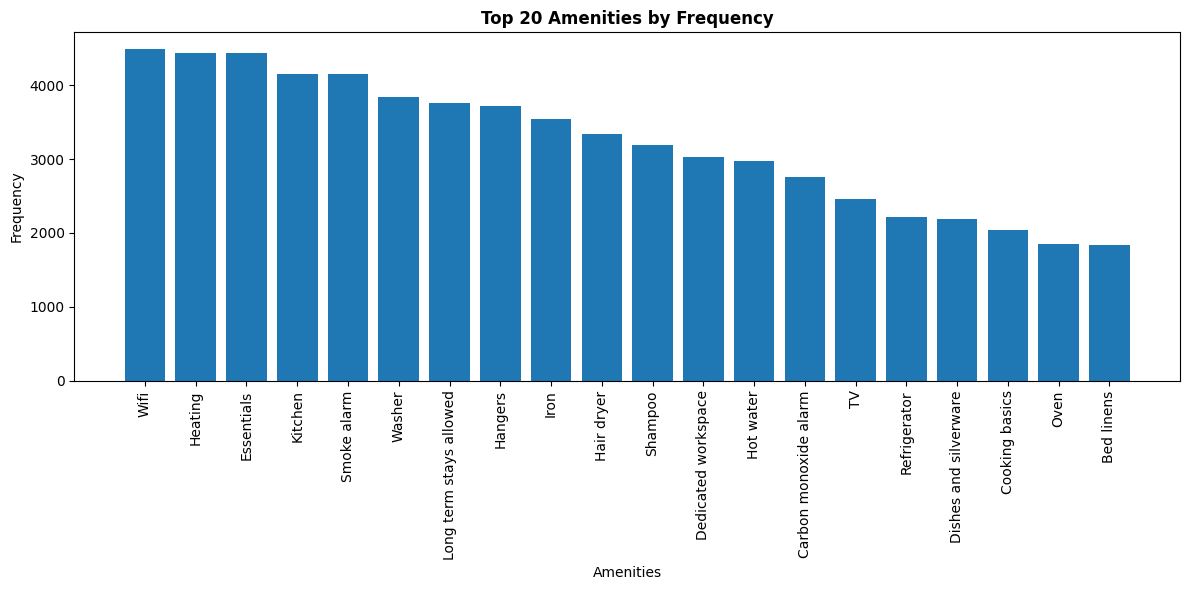

In [72]:
from collections import Counter
flat_list = [item for sublist in camden_neigh_listings['amenities'] for item in sublist]

frequency_count = Counter(flat_list)

strings = list(frequency_count.keys())
frequencies = list(frequency_count.values())

strings, frequencies = zip(*frequency_count.most_common(20))

plt.figure(figsize=(12, 6))
plt.bar(strings, frequencies)
plt.xlabel('Amenities')
plt.ylabel('Frequency')
plt.title('Top 20 Amenities by Frequency', fontweight='bold',size='large')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

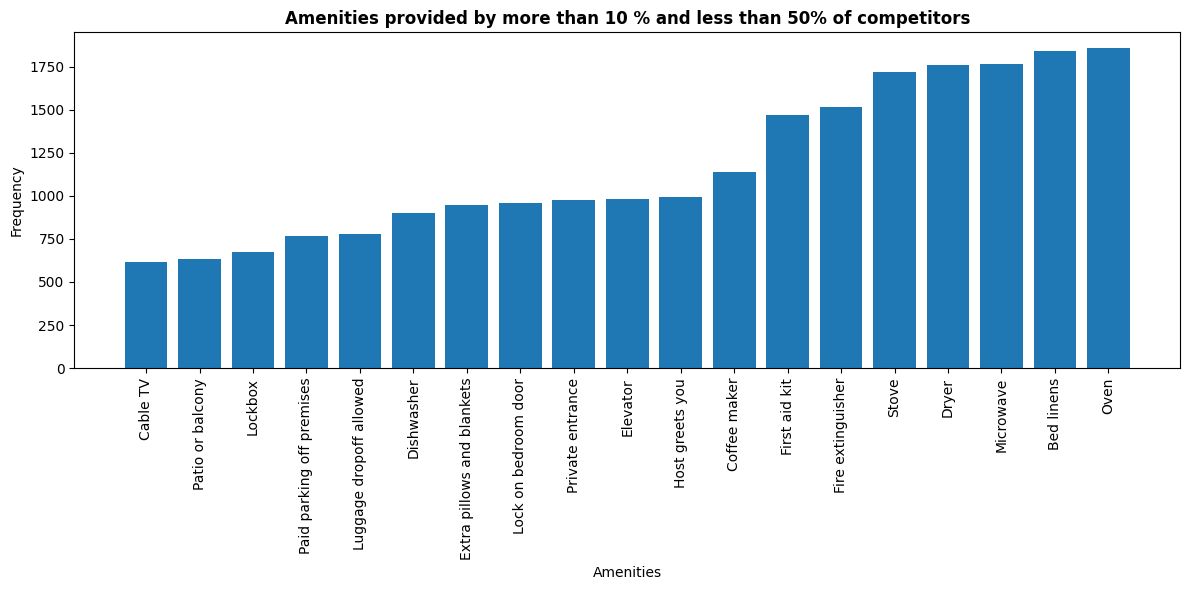

In [73]:
flat_list = [item for sublist in camden_neigh_listings['amenities'] for item in sublist]

frequency_count = Counter(flat_list)

strings = list(frequency_count.keys())
frequencies = list(frequency_count.values())

min_freq = 600
max_freq = 2000

# Filter amenities within the frequency range
amenities_within_range = [(amenity, freq) for amenity, freq in frequency_count.items() if min_freq <= freq < max_freq]
amenities_name = [amenity for amenity, freq in frequency_count.items() if min_freq <= freq < max_freq]

# Sort by frequency in ascending order
amenities_within_range.sort(key=lambda x: x[1])

# Unzip the filtered list to get strings and frequencies
strings_within_range, frequencies_within_range = zip(*amenities_within_range)

plt.figure(figsize=(12, 6))
plt.bar(strings_within_range, frequencies_within_range)
plt.xlabel('Amenities')
plt.ylabel('Frequency')
plt.title(f'Amenities provided by more than 10 % and less than 50% of competitors',fontweight='bold',size='large')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()


In [74]:
common_terms = list(set(conc_amen) & set(amenities_name))

In [75]:
len(common_terms)/len(amenities_name)

0.2631578947368421

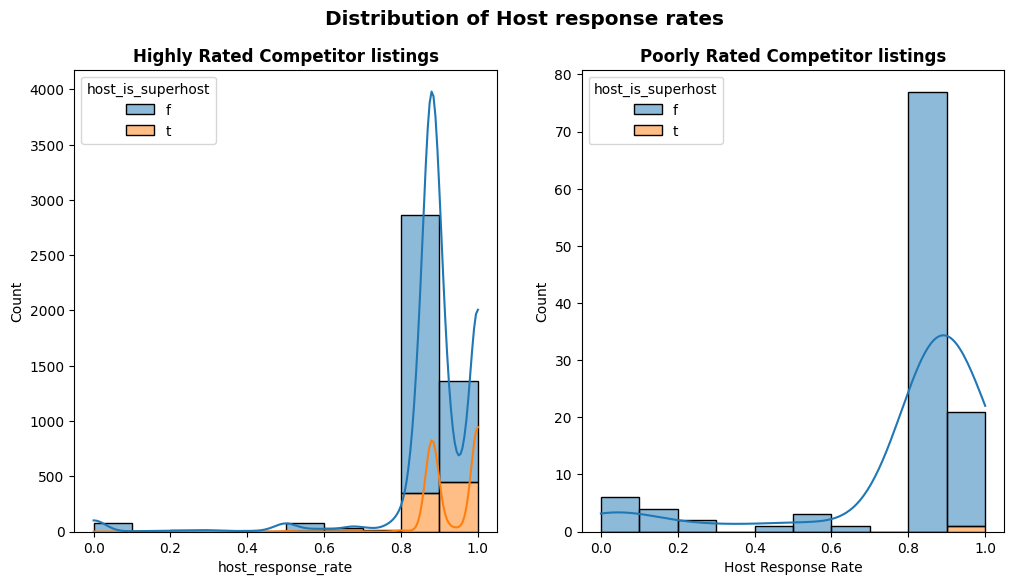

In [76]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
sns.histplot(data=high_perform_neigh,x='host_response_rate',hue='host_is_superhost',kde=True,binwidth=0.1,multiple='stack',ax=ax[0])
plt.xlabel('Host Response Rate')
ax[0].set_title("Highly Rated Competitor listings",fontweight='bold',size='large')

sns.histplot(data=poor_perform_neigh,x='host_response_rate',hue='host_is_superhost',kde=True,binwidth=0.1,multiple='stack',ax=ax[1])
plt.xlabel('Host Response Rate')
ax[1].set_title("Poorly Rated Competitor listings",fontweight='bold',size='large')

plt.suptitle("Distribution of Host response rates",fontweight='bold',size='x-large')

plt.show()

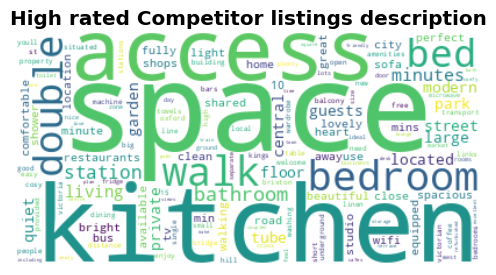

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

text_data=clean_text_func(high_perform_neigh['description'])

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform([text_data])

features = vectorizer.get_feature_names_out()

word_freq = dict(zip(features, tfidf_matrix.toarray()[0]))

# Creating a word cloud with emphasized words based on TF-IDF scores
wordcloud = WordCloud(background_color='white')

# Generate word cloud
wordcloud.generate_from_frequencies(word_freq)
plt.figure(figsize=(6, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("High rated Competitor listings description",fontweight='bold',size='x-large')
plt.axis('off')
plt.show()

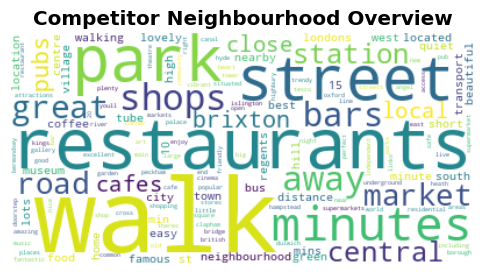

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

text_data=clean_text_func(high_perform_neigh['neighborhood_overview'])

#TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform([text_data])

features = vectorizer.get_feature_names_out()

word_freq = dict(zip(features, tfidf_matrix.toarray()[0]))

wordcloud = WordCloud(background_color='white')


wordcloud.generate_from_frequencies(word_freq)
plt.figure(figsize=(6, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Competitor Neighbourhood Overview",fontweight='bold',size='x-large')
plt.axis('off')
plt.show()

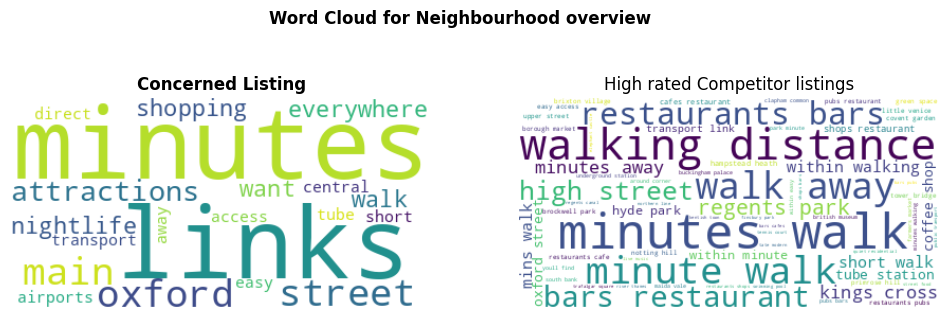

In [79]:
#LISTING Neighbourhood overview


wordcloud1 = WordCloud(stopwords = stopwords,collocations=True,background_color='white',min_word_length=4).generate(clean_text_func(conc_listing['neighborhood_overview']))

wordcloud2= WordCloud(stopwords = stopwords,collocations=True,background_color='white',min_word_length=4,collocation_threshold=2).generate(clean_text_func(high_perform_neigh['neighborhood_overview']))



fig,ax=plt.subplots(1,2, figsize=(12,4))
ax[0].imshow(wordcloud1, interpolation='bilInear')
ax[0].set_title("Concerned Listing",fontweight='bold',size='large')
ax[0].axis('off')

ax[1].imshow(wordcloud2, interpolation='bilInear')
ax[1].set_title("High rated Competitor listings")
ax[1].axis('off')



plt.suptitle("Word Cloud for Neighbourhood overview",fontweight='bold',size='large')


plt.show()

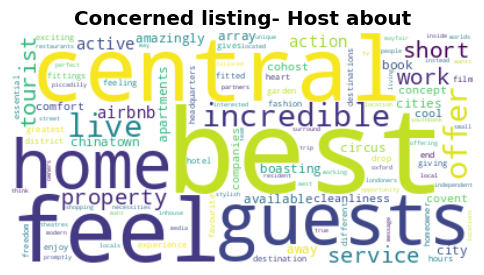

In [80]:
text_data=clean_text_func(conc_listing['host_about'])

# TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform([text_data])

features = vectorizer.get_feature_names_out()

word_freq = dict(zip(features, tfidf_matrix.toarray()[0]))

wordcloud = WordCloud(background_color='white')

wordcloud.generate_from_frequencies(word_freq)
plt.figure(figsize=(6, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Concerned listing- Host about",fontweight='bold',size='x-large')
plt.axis('off')
plt.show()

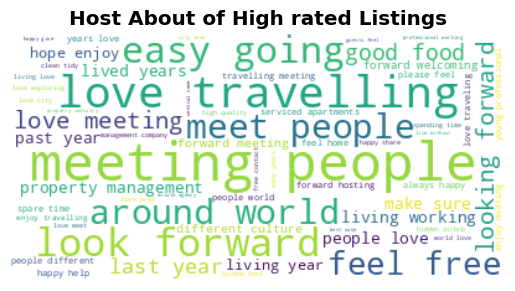

In [81]:
#LISTING Host About

wordcloud2= WordCloud(stopwords = stopwords,collocations=True,background_color='white',min_word_length=4,collocation_threshold=3).generate(clean_text_func(high_perform_neigh['host_about']))

plt.imshow(wordcloud2, interpolation='bilInear')
plt.title("Host About of High rated Listings",fontweight='bold',size='x-large')
plt.axis('off')

plt.show()

## Review Sentiment Analysis


In [82]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
scorer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [83]:
def calculate_sentiment(comment):
    return(scorer.polarity_scores(comment)['compound'])

In [84]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngrams(corpus, ngram_range, stop_words, n):
    vec = CountVectorizer(stop_words=stop_words, ngram_range=ngram_range).fit(corpus)

    bag_of_words = vec.transform(corpus)

    sum_words = bag_of_words.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    common_words = words_freq[:n]
    words = []
    freqs = []
    for word, freq in common_words:
        words.append(word)
        freqs.append(freq)

    df = pd.DataFrame({'Word': words, 'Freq': freqs})
    return df


In [85]:
from whatthelang import WhatTheLang
wtl = WhatTheLang()
def langid_pred(text):
    if len(text)!=0:
      try:
        language = wtl.predict_lang(text)
        return language
      except ValueError as e:
        return 'unknown'

    else:
      return 'unknown'

In [86]:
from googletrans import Translator

def translate_func(my_text):

  translator = Translator()

  translated_text = translator.translate(my_text, src='fr', dest='en')
  return translated_text.text

##Review polarity of all listings


In [87]:
rev_listings=pd.merge(listings,reviews,on='listing_id',how="left")
rev_listings.shape

(49508, 71)

In [88]:
len(rev_listings[rev_listings['reviewer_id'].notnull()]['listing_id'].unique())
overall_reviewed_listings=rev_listings[rev_listings['reviewer_id'].notnull()].copy()

In [89]:
overall_reviewed_listings.shape

(39234, 71)

In [90]:
#Language detection
import swifter
overall_reviewed_listings['rev_language']=overall_reviewed_listings['comments'].swifter.apply(langid_pred)

Pandas Apply:   0%|          | 0/39234 [00:00<?, ?it/s]

In [91]:
langs=pd.DataFrame(overall_reviewed_listings['rev_language'].value_counts())

In [92]:
langs

,rev_language
en,34536
fr,1676
es,863
de,583
it,360
zh,283
ko,207
CANT_PREDICT,195
pt,129
nl,92


In [93]:
#Filter only English
eng_overall_listings=overall_reviewed_listings[overall_reviewed_listings['rev_language']=='en'].copy()
eng_overall_listings.loc[:,'sentiment'] = eng_overall_listings['comments'].swifter.apply(calculate_sentiment)


Pandas Apply:   0%|          | 0/34536 [00:00<?, ?it/s]

In [94]:
from textblob import TextBlob
eng_overall_listings['sentiment_blob'] = eng_overall_listings['comments'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [95]:
eng_overall_listings.shape

(34536, 74)

In [96]:
overall_mean_sentiment=eng_overall_listings.groupby('listing_id')['sentiment'].mean().reset_index()
overall_mean_sentiment.columns = ['listing_id', 'mean_sentiment_score']

In [97]:
listings=pd.merge(listings,overall_mean_sentiment,on='listing_id',how='left')

In [98]:
listings['mean_sentiment_score'].notnull().sum()

10328

In [99]:
camden_neigh_listings.shape

(4668, 66)

In [100]:
#Camden reviews
reviewed_camden=eng_overall_listings[eng_overall_listings['neighbourhood_cleansed']=='Camden']
#Competitor Set reviews
reviewed_neigh=eng_overall_listings[eng_overall_listings['neighbourhood_cleansed'].isin(camden_neighs)]

##Concerned Listing

Listing under consideration ID: 39934731

In [101]:
#Concerned Listing Reviews analysis
conc_reviews=conc_listing.merge(reviews,on='listing_id',how="left")

In [102]:
conc_reviews['rev_language']=conc_reviews['comments'].apply(langid_pred)

In [103]:
conc_reviews

,listing_id,name,description,neighborhood_overview,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,...,bathroom_type,count_amenities,Price Type,intop10_Neigh,id,date,reviewer_id,reviewer_name,comments,rev_language
0,39934731,"Soho Home, Brilliant Location, 2 Beds, Sleeps ...",This central Soho apartment is also only minut...,It is minutes from Oxford Street and all the m...,2013-06-12,London,Soho Resident or Homeowner? We are an active '...,within a few hours,0.86,0.93,...,private,22,Economical (50-100 $),t,667709162,2020-09-25,16217055,Leonardo,"Nice apartment in busy soho, clean, with a nic...",en
1,39934731,"Soho Home, Brilliant Location, 2 Beds, Sleeps ...",This central Soho apartment is also only minut...,It is minutes from Oxford Street and all the m...,2013-06-12,London,Soho Resident or Homeowner? We are an active '...,within a few hours,0.86,0.93,...,private,22,Economical (50-100 $),t,613605998,2020-03-02,59642624,Chelsea,We had a great stay. Check in was very easy! \...,en
2,39934731,"Soho Home, Brilliant Location, 2 Beds, Sleeps ...",This central Soho apartment is also only minut...,It is minutes from Oxford Street and all the m...,2013-06-12,London,Soho Resident or Homeowner? We are an active '...,within a few hours,0.86,0.93,...,private,22,Economical (50-100 $),t,615101306,2020-03-07,232471329,Didier,Appartement très bruyant yant car pas de doubl...,fr


In [104]:
#Translate French review to Eng
eng_text=translate_func(str(conc_reviews[conc_reviews['rev_language']=='fr']['comments'].values[0]))
conc_reviews.loc[2,'comments']=eng_text
eng_text

'Very noisy apartment yant because no double glazing, and no heating in the bathroom, no more hot water either from the second day.Otherwise very well placed, in very lively neighborhood.'

In [105]:
#Review polarity
conc_reviews.loc[:,'sentiment'] = conc_reviews['comments'].apply(calculate_sentiment)
conc_reviews[['comments','sentiment']]

,comments,sentiment
0,"Nice apartment in busy soho, clean, with a nic...",0.8074
1,We had a great stay. Check in was very easy! \...,0.9002
2,Very noisy apartment yant because no double gl...,-0.2516


In [106]:
conc_reviews['comments'][2] #French review

'Very noisy apartment yant because no double glazing, and no heating in the bathroom, no more hot water either from the second day.Otherwise very well placed, in very lively neighborhood.'

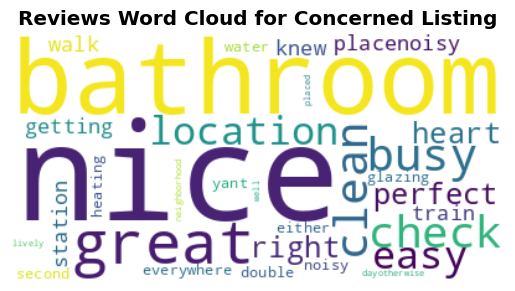

In [107]:

wordcloud = WordCloud(stopwords = stopwords,collocations=False,background_color='white',min_word_length=4).generate(clean_text_func(conc_reviews['comments']))
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.title("Reviews Word Cloud for Concerned Listing",fontweight='bold',size='x-large')
plt.show()

# Translation of reviews was attempted but not possible due to API limitations

In [108]:
'''#Translate french ones
for index, row in reviewed_camden[reviewed_camden['rev_language']=='fr'].iterrows():
        translated_text = translate_func(row['comments'])
        reviewed_camden.at[index, 'comments'] = translated_text
'''

"#Translate french ones\nfor index, row in reviewed_camden[reviewed_camden['rev_language']=='fr'].iterrows():\n        translated_text = translate_func(row['comments'])\n        reviewed_camden.at[index, 'comments'] = translated_text\n"

## Neighbourhood listings

In [109]:
custom_stopwords=["london","flat","room","thing","stay","apartment","will","house","travel","place","minute","things","note","guest","recommend","no","description","Unknown","term","soho","camden","area","automated","great","stay"]


In [110]:
def preprocess_text(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove stopwords (both English and custom)
    stopwords = set(nltk.corpus.stopwords.words('english')).union(custom_stopwords)
    filtered_tokens = [token for token in tokens if token.lower() not in stopwords]

    # Reconstruct the text without stopwords
    processed_text = ' '.join(filtered_tokens)
    return processed_text


In [111]:
reviewed_neigh['clean_comments']=reviewed_neigh['comments'].swifter.apply(preprocess_text)

Pandas Apply:   0%|          | 0/14027 [00:00<?, ?it/s]

<ipython-input-111-0366308b12af>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



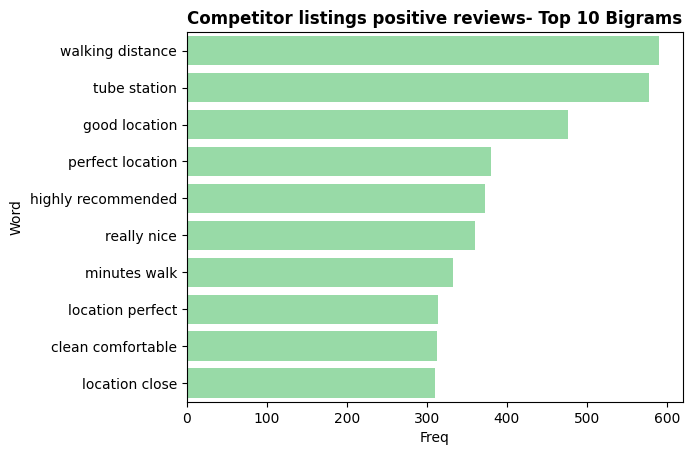

In [112]:
from nltk.corpus import stopwords
from sklearn.feature_extraction import text

grams = get_top_ngrams(reviewed_neigh[reviewed_neigh['sentiment']>=0.05]['clean_comments'], (2,2), 'english', 10)
sns.barplot(x='Freq', y='Word', color=colors[2], data=grams)
plt.title('Competitor listings positive reviews- Top 10 Bigrams',fontweight='bold',size='large')
plt.show()

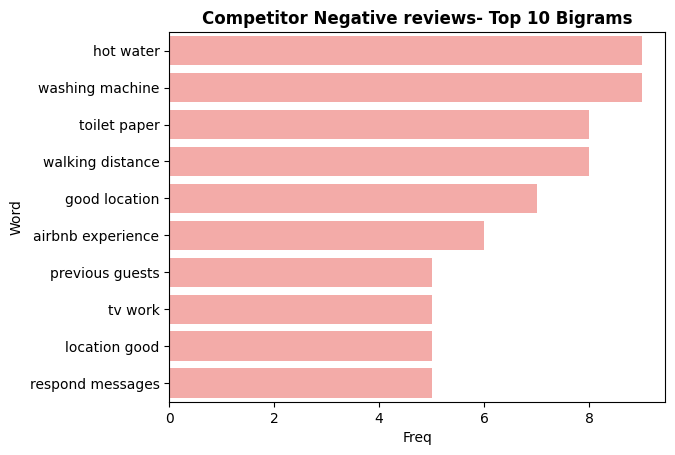

In [113]:
n=10
stop_words = 'english'
grams = get_top_ngrams(reviewed_neigh[reviewed_neigh['sentiment']<=-0.05]['clean_comments'], (2,2), stop_words, n)
sns.barplot(x='Freq', y='Word', color=colors[3], data=grams)
plt.title('Competitor Negative reviews- Top 10 Bigrams',fontweight='bold',size='large')
plt.show()

# Price prediction - Linear, Random forest

##Multicollinearlity


In [114]:
reg_cols=['host_response_rate','host_response_time_type','host_acceptance_rate','host_is_superhost','host_identity_verified',
          'room_type','accommodates','count_amenities','minimum_nights',
       'maximum_nights','instant_bookable','availability_60','number_of_reviews_l30d',
        'review_scores_accuracy','review_scores_cleanliness','review_scores_rating', 'review_scores_checkin','review_scores_communication', 'review_scores_location','review_scores_value',
     'instant_bookable','calculated_host_listings_count','reviews_per_month',
      'bathroom_type','price','bathroom_count','host_since(yrs)','intop10_Neigh']


reg_cols_iter2=['host_response_rate','host_is_superhost','host_identity_verified','accommodates','count_amenities','instant_bookable','availability_60','calculated_host_listings_count', 'bathroom_type','price','review_scores_value','room_type','review_scores_rating','intop10_Neigh']


In [115]:
price_pred=listings[reg_cols_iter2].copy()

In [116]:
price_pred=price_pred[price_pred['price']<=400]

In [117]:
price_pred['intop10_Neigh'].value_counts()

t    14234
f     6484
Name: intop10_Neigh, dtype: int64

In [118]:
price_pred.shape

(20718, 14)

In [119]:
price_pred.isnull().sum()

host_response_rate                0
host_is_superhost                 0
host_identity_verified            0
accommodates                      0
count_amenities                   0
instant_bookable                  0
availability_60                   0
calculated_host_listings_count    0
bathroom_type                     0
price                             0
review_scores_value               0
room_type                         0
review_scores_rating              0
intop10_Neigh                     0
dtype: int64

In [120]:
encoded_pred=pd.get_dummies(price_pred)

In [121]:
encoded_pred.head()

,host_response_rate,accommodates,count_amenities,availability_60,calculated_host_listings_count,price,review_scores_value,review_scores_rating,host_is_superhost_f,host_is_superhost_t,...,instant_bookable_f,instant_bookable_t,bathroom_type_private,bathroom_type_shared,room_type_entire home/apt,room_type_hotel room,room_type_private room,room_type_shared room,intop10_Neigh_f,intop10_Neigh_t
0,0.98,5,45,52,33,128.0,10.0,100.0,1,0,...,0,1,1,0,1,0,0,0,0,1
1,0.88,1,21,0,35,70.0,8.0,91.0,1,0,...,0,1,1,0,0,0,1,0,0,1
2,0.88,2,25,60,1,39.0,10.0,99.0,1,0,...,1,0,1,0,0,0,1,0,1,0
3,1.00,1,29,46,1,40.0,10.0,100.0,0,1,...,0,1,0,1,0,0,1,0,0,1
4,0.88,4,32,0,3,200.0,10.0,100.0,0,1,...,0,1,1,0,1,0,0,0,0,1


In [122]:
encoded_pred['price']=np.log(encoded_pred['price'])

In [123]:
from sklearn.preprocessing import StandardScaler

X = encoded_pred.drop('price', axis=1)
y = encoded_pred['price']

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [124]:
#Get VIF Scores
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor # using package of testing VIF in statsmodels
from statsmodels.formula.api import ols
vif = [variance_inflation_factor(exog=X.values, exog_idx=i) for i in range(X.shape[1])]

vif_table = pd.DataFrame({'coef_name': X.columns, 'vif': np.around(vif,3)})
print(vif_table)

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning:

divide by zero encountered in double_scalars



                         coef_name          vif
0               host_response_rate        1.057
1                     accommodates        1.482
2                  count_amenities        1.235
3                  availability_60        1.073
4   calculated_host_listings_count        1.060
5              review_scores_value        2.835
6             review_scores_rating        2.842
7              host_is_superhost_f  1785183.657
8              host_is_superhost_t  1785183.657
9         host_identity_verified_f   605348.549
10        host_identity_verified_t   390192.942
11              instant_bookable_f   359381.279
12              instant_bookable_t   359381.279
13           bathroom_type_private   269602.675
14            bathroom_type_shared  6023568.505
15       room_type_entire home/apt          inf
16            room_type_hotel room          inf
17          room_type_private room          inf
18           room_type_shared room          inf
19                 intop10_Neigh_f    79

In [125]:
#Drop inf columns
X.drop(['host_is_superhost_f','instant_bookable_f','host_identity_verified_f','bathroom_type_shared','room_type_private room','intop10_Neigh_f'],axis=1,inplace=True)

In [126]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
vif = [variance_inflation_factor(exog=X.values, exog_idx=i) for i in range(X.shape[1])]


vif_table = pd.DataFrame({'coef_name': X.columns, 'vif': np.around(vif,3)})
print(vif_table)

                         coef_name    vif
0               host_response_rate  1.057
1                     accommodates  1.482
2                  count_amenities  1.235
3                  availability_60  1.073
4   calculated_host_listings_count  1.060
5              review_scores_value  2.835
6             review_scores_rating  2.842
7              host_is_superhost_t  1.147
8         host_identity_verified_t  1.065
9               instant_bookable_t  1.043
10           bathroom_type_private  1.991
11       room_type_entire home/apt  2.458
12            room_type_hotel room  1.058
13           room_type_shared room  1.021
14                 intop10_Neigh_t  1.050


In [127]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=123)

In [128]:
def final_result(y_test,y_pred):
    dic = {"actual_y" : y_test.values, "predicted_y" : y_pred}
    result = pd.DataFrame(dic)
    return result

## Linear Regression

In [129]:
from sklearn import metrics
def print_evaluate(true,predicted):
    mae = metrics.mean_absolute_error(true,predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true,predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('\nMAE:', mae)
    print('\nMSE:', mse)
    print('\nRMSE:', rmse)
    print('\nR2 Square', r2_square)

In [130]:
from sklearn.linear_model import LinearRegression

model= LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [131]:
r_squared=model.score(X_test, y_test)
n = len(y_test)
p = X_test.shape[1]
y_pred =model.predict(X_test)
print("Error/ Accuracy Analysis :- ")
print_evaluate(y_test,model.predict(X_test))
adjusted_r_squared = 1 - (((1 - r_squared) * (n - 1)) / (n - p))
print("\nAdjusted R2:",adjusted_r_squared)

Error/ Accuracy Analysis :- 

MAE: 0.3117326039793866

MSE: 0.16734518191346595

RMSE: 0.4090784544723248

R2 Square 0.637533358418917

Adjusted R2: 0.6363043603607588


In [132]:
y_pred

array([4.22204086, 4.74859045, 3.86526027, ..., 3.47340125, 4.76272956,
       4.65534447])

In [133]:
reg_df=final_result(np.exp(y_test),np.exp(y_pred)).head(100)

In [134]:
reg_df

,actual_y,predicted_y
0,95.0,68.172473
1,70.0,115.421478
2,45.0,47.715690
3,29.0,32.514325
4,40.0,121.571381
...,...,...
95,80.0,78.585819
96,254.0,111.578765
97,50.0,50.728030
98,45.0,39.016604


In [135]:
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance':model.coef_})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)


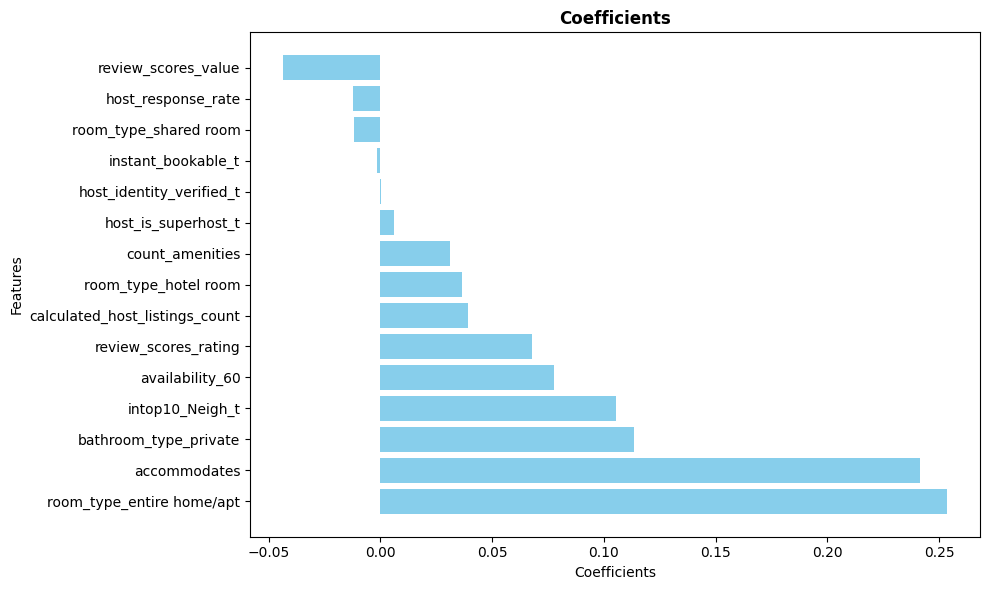

In [136]:
plt.figure(figsize=(10, 6))
plt.barh(y=feature_importance['Feature'], width=feature_importance['Importance'], color='skyblue')
plt.ylabel('Features')
plt.xlabel('Coefficients')
plt.title('Coefficients',fontweight='bold',size='large')
plt.tight_layout()
plt.show()

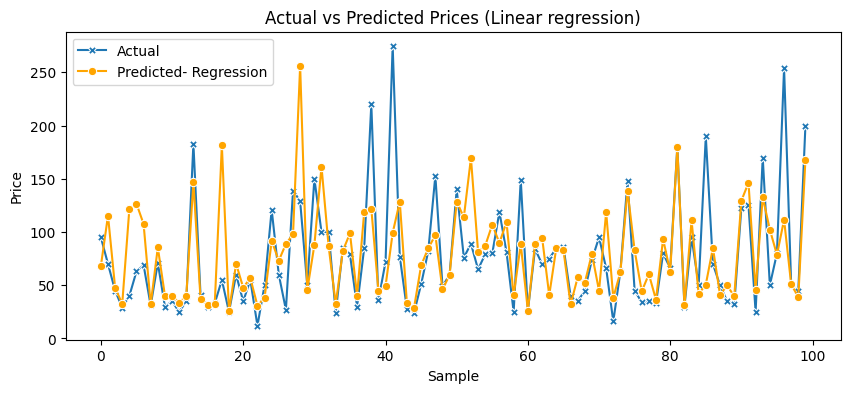

In [137]:
plt.figure(figsize=(10, 4))


sns.lineplot(data=reg_df['actual_y'], marker='X', label='Actual')

sns.lineplot(data=reg_df['predicted_y'], marker='o', color='orange', label='Predicted- Regression')

plt.title('Actual vs Predicted Prices (Linear regression)')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()
plt.show()

# **Predict review polarity**

In [138]:
reg_cols_iter2=['host_since(yrs)','host_response_rate','host_is_superhost','host_identity_verified','accommodates','count_amenities','instant_bookable','price','calculated_host_listings_count', 'bathroom_type','room_type','intop10_Neigh','mean_sentiment_score']


In [139]:
pol_pred=listings[reg_cols_iter2].copy()

In [140]:
#Drop null sentiment scores
pol_pred.dropna(subset=['mean_sentiment_score'],inplace=True)

In [141]:
encoded_pred_polarity=pd.get_dummies(pol_pred)

In [142]:
encoded_pred_polarity.shape

(10328, 21)

#Classification

In [143]:
encoded_pred_polarity.loc[encoded_pred_polarity['mean_sentiment_score']>=0.05,'overall_polarity']='Positive'
encoded_pred_polarity.loc[encoded_pred_polarity['mean_sentiment_score']==0,'overall_polarity']='Neutral'
encoded_pred_polarity.loc[encoded_pred_polarity['mean_sentiment_score']<=-0.05,'overall_polarity']='Negative'

In [144]:
encoded_pred_polarity['overall_polarity'].value_counts()

Positive    10132
Negative      106
Neutral        69
Name: overall_polarity, dtype: int64

In [145]:
encoded_pred_polarity.drop(['mean_sentiment_score'],axis=1,inplace=True)

In [146]:
encoded_pred_polarity.dropna(inplace=True)

In [147]:
encoded_pred_polarity.isnull().sum()

host_since(yrs)                   0
host_response_rate                0
accommodates                      0
count_amenities                   0
price                             0
calculated_host_listings_count    0
host_is_superhost_f               0
host_is_superhost_t               0
host_identity_verified_f          0
host_identity_verified_t          0
instant_bookable_f                0
instant_bookable_t                0
bathroom_type_private             0
bathroom_type_shared              0
room_type_entire home/apt         0
room_type_hotel room              0
room_type_private room            0
room_type_shared room             0
intop10_Neigh_f                   0
intop10_Neigh_t                   0
overall_polarity                  0
dtype: int64

In [148]:
from sklearn.preprocessing import StandardScaler

X_pol = encoded_pred_polarity.drop('overall_polarity', axis=1)
y_pol = encoded_pred_polarity['overall_polarity']

scaler = StandardScaler()
X_pol = pd.DataFrame(scaler.fit_transform(X_pol), columns=list(X_pol.columns))

In [149]:
X_pol.drop(['host_identity_verified_f','intop10_Neigh_f','host_is_superhost_f','bathroom_type_shared','room_type_hotel room','instant_bookable_f','room_type_private room'],axis=1,inplace=True)

In [150]:
#Get VIF Scores
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols

vif = [variance_inflation_factor(exog=X_pol.values, exog_idx=i) for i in range(X_pol.shape[1])]

vif_table = pd.DataFrame({'coef_name': X_pol.columns, 'vif': np.around(vif,3)})
print(vif_table)

                         coef_name    vif
0                  host_since(yrs)  1.064
1               host_response_rate  1.054
2                     accommodates  1.520
3                  count_amenities  1.187
4                            price  1.088
5   calculated_host_listings_count  1.035
6              host_is_superhost_t  1.128
7         host_identity_verified_t  1.060
8               instant_bookable_t  1.060
9            bathroom_type_private  1.943
10       room_type_entire home/apt  2.323
11           room_type_shared room  1.021
12                 intop10_Neigh_t  1.063


In [151]:
X_train_pol, X_test_pol, y_train_pol, y_test_pol = train_test_split(X_pol,y_pol, test_size=0.2, random_state=123)

In [152]:
from sklearn.ensemble import RandomForestClassifier

In [153]:
clf = RandomForestClassifier(n_estimators = 100)

clf.fit(X_train_pol, y_train_pol)


y_pred_pol = clf.predict(X_test_pol)

from sklearn import metrics
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test_pol, y_pred_pol))

ACCURACY OF THE MODEL:  0.9806013579049466


In [154]:
y_test_pol

15943    Positive
12535    Positive
10532    Positive
17461    Positive
16142    Positive
           ...   
198      Positive
260      Positive
2507     Positive
15629    Positive
10202    Positive
Name: overall_polarity, Length: 2062, dtype: object

In [155]:
final_result(y_test_pol,y_pred_pol)

,actual_y,predicted_y
0,Positive,Positive
1,Positive,Positive
2,Positive,Positive
3,Positive,Positive
4,Positive,Positive
...,...,...
2057,Positive,Positive
2058,Positive,Positive
2059,Positive,Positive
2060,Positive,Positive


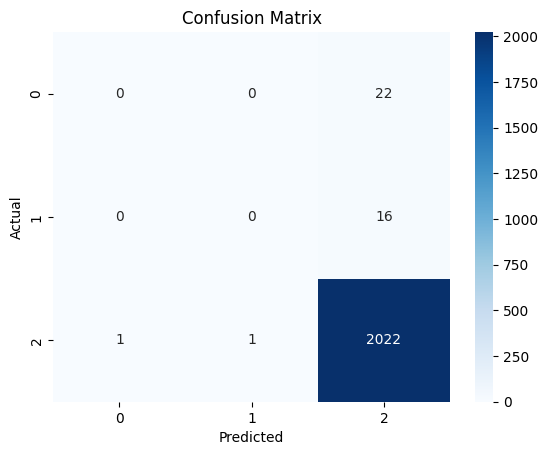

In [156]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_pol, y_pred_pol)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Text(0.5, 1.0, 'Feature Importance')

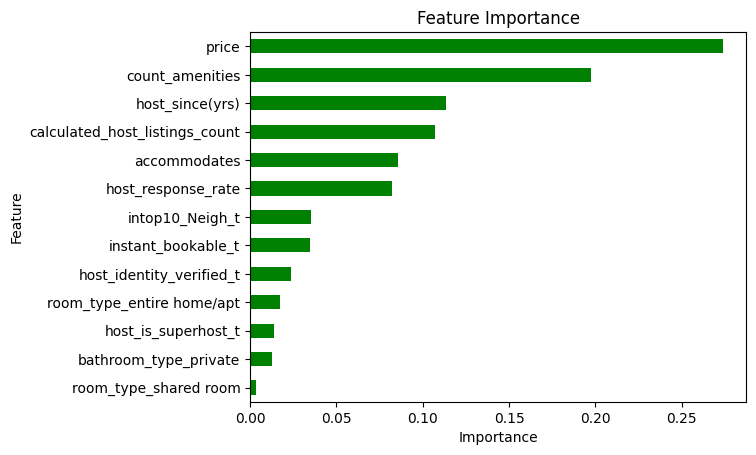

In [157]:
global_importances = pd.Series(clf.feature_importances_, index=X_train_pol.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
